# Facemask Detection Using Tensorflow in Python

In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imutils import paths
import cv2

### Intialize parameters

In [26]:
INIT_LR = 1e-4  # Learning rate
EPOCHS = 20
BS = 32  # Batch size
DIRECTORY = "dataset"  # Path to your dataset folder
CATEGORIES = ["with_mask", "without_mask"]

### Load images and preprocess data

In [27]:
print("[INFO] Loading images...")
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
        data.append(image)
        labels.append(category)

[INFO] Loading images...


### Converting labels to binary format

In [28]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = tf.keras.utils.to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

### Split data into training and testing sets

In [29]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

### Augmenting data

In [30]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

### Loading the MobileNetV2 model and then adding the layers

In [31]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

C:\Users\vasuc\AppData\Local\Temp\ipykernel_3752\1446842784.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


### Compiling the model

In [32]:
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] Compiling model...


c:\Users\vasuc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### Training the model

In [33]:
print("[INFO] Training model...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    shuffle=True)

[INFO] Training model...


c:\Users\vasuc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


c:\Users\vasuc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_318']. Received: the structure of inputs=*
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5966 - loss: 0.7236 - val_accuracy: 0.9783 - val_loss: 0.2406
Epoch 2/20
 1/34 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 1.0000 - loss: 0.2030

c:\Users\vasuc\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.2030   
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9685 - loss: 0.2270 - val_accuracy: 0.9891 - val_loss: 0.1036
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9688 - loss: 0.1583
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9866 - loss: 0.1185 - val_accuracy: 0.9928 - val_loss: 0.0592
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0656
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9880 - loss: 0.0793 - val_accuracy: 0.9928 - val_loss: 0.0422
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0788   
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9960 - loss: 0.0613 - val_accuracy: 0.9928 - val_loss: 0.0320
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0283
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9875 - loss: 

### Evaluating the model and saving it

In [34]:
# Evaluate the model
print("[INFO] Evaluating model...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# Save the model
print("[INFO] Saving mask detector model...")
model.save("mask_detector.h5")

[INFO] Evaluating model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 854ms/step


              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276

[INFO] Saving mask detector model...


### Visualizing the training results

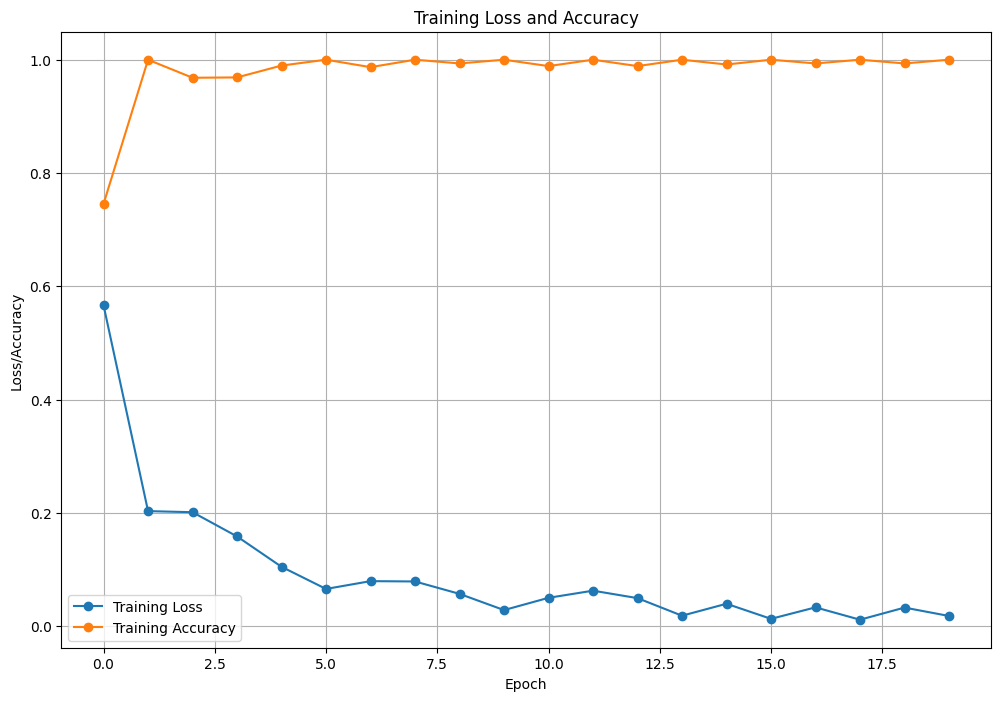

In [35]:
# First, let's check what data we have
available_epochs = len(H.history['loss'])
epochs_range = np.arange(0, available_epochs)

plt.figure(figsize=(12, 8))

# Plot training loss
plt.plot(epochs_range, H.history['loss'], label='Training Loss', marker='o')

# Only plot validation metrics if they exist for all epochs
if 'val_loss' in H.history and len(H.history['val_loss']) == available_epochs:
    plt.plot(epochs_range, H.history['val_loss'], label='Validation Loss', marker='o')

# Plot training accuracy
plt.plot(epochs_range, H.history['accuracy'], label='Training Accuracy', marker='o')

# Only plot validation accuracy if it exists for all epochs
if 'val_accuracy' in H.history and len(H.history['val_accuracy']) == available_epochs:
    plt.plot(epochs_range, H.history['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('training_plot.png')
plt.show()